In [44]:
import os
import time
import math
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib 
import matplotlib.pyplot as plt
# from core.utils import get_file,mae_mse
from matplotlib.pyplot import MultipleLocator
plt.rcParams['font.sans-serif'] = ['SimHei']#显示中文
matplotlib.rcParams['axes.unicode_minus'] =False#显示负号

from core.data_processor import DataLoader
from core.model import Model
from core.utils import mae_mse
from keras import backend as K
from keras.models import load_model

# 数据处理

In [2]:
configs = json.load(open('config.json', 'r'))
save_path = configs['data']['save_path']
csv_path = save_path#txt转成csv原始裂缝数据
ori_path = configs['data']['origin_path']#原始裂缝数据
test_path = configs['data']['testpath']
train_path = configs['data']['trainpath']
valid_path = configs['data']['validpath']

ff = 17#傅里叶变化分量

In [3]:
def get_file(path):
    temp = []
    for i in os.listdir(path):
        path2 = os.path.join(path, i)  # 拼接绝对路径
        if os.path.isdir(path2):  # 判断如果是文件夹,调用本身
            get_file(path2)
        else:
            temp.append(i)
    return temp

In [4]:
#傅里叶变换
def Fourier_transforms(df):    
    if 'Date' in list(df.columns):
        df = df.set_index(df.Date).drop(['Date'],axis=1)
    temp = pd.DataFrame(
        columns=list(df.columns))
    for col in list(df.columns):
        fft = np.fft.fft(np.asarray(list(df[col])))
        fft_df = pd.DataFrame({'fft': fft})
        fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
        fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
        fft_list = np.asarray(fft_df['fft'].tolist())
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[ff:-ff] = 0
        temp[col] = [(i.real) for i in np.fft.ifft(fft_list_m10)]
    temp.index = df.index
    df_1 = df[:2]
    df_2 = temp[2:]
    temp = df_1.append(df_2)
    df_3 = df[-2:]
    df_4 = temp[:-2]
    temp = df_4.append(df_3)
    return temp

In [5]:
# 解析原始数据，保存成csv
file_ori = get_file(ori_path)
if file_ori:
    for file in file_ori:
        if not '环境量' in file:  # and 'D3J1' in file:
            file_ = os.path.join(ori_path, file)
            df = pd.read_csv(file_).dropna()
            file_name = file.split('.')[0].split('_')[-1]
            if df.shape[0]:
                df.columns = ['With_temp', 'rainfall']
                index = np.array(list(df.index))
                temp_frame = pd.DataFrame(
                    {'Date': index[:, 0], 'Crackwidth': index[:, 1], 'With_temp': df['With_temp'], 'Rainfall': list(df.rainfall)})
                temp_frame.Date = temp_frame.Date.astype('int')
                temp_frame = temp_frame.set_index(
                    temp_frame.Date).drop(['Date'], axis=1)
                filename = os.path.join(save_path, file_name+'.csv')
                temp_frame.to_csv(filename, sep=',',
                                  header=True, index=True)
                # plot_width(list(temp_frame.Crackwidth),file_name)
temp_frame.head()

,Crackwidth,With_temp,Rainfall
Date,,,
19850924,0.00,20.43,1000000.0
19860516,1.35,10.07,1000000.0
19860614,0.81,10.66,1000000.0
19860721,0.85,12.94,1000000.0
19860822,0.71,14.19,1000000.0


In [6]:
# 解析环境量，去除异常值
file = os.path.join(ori_path, '环境量.TXT')
df = pd.read_csv(file)
df.columns = ['rainfall']
index = np.array(list(df.index))
date = index[:, 0]
Upstream = index[:, 1]
Downstream = index[:, 2]
Temprate = index[:, 3]

temp = []
i=0
for d in Temprate:
#     print(i,d.split(' ')[-1])
    temp.append((d.split(' ')[-1]))
    i+=1
Temprate = temp

env_frame = pd.DataFrame({'Date': date, 'Upstream': Upstream, 'Downstream': Downstream,
                          'Temprate': Temprate, 'Rainfall': list(df.rainfall)})
env_frame = env_frame.set_index(env_frame.Date).drop(['Date'], axis=1)

env_frame.Temprate=env_frame.Temprate.str.strip()

env_frame.Temprate = env_frame.Temprate.replace('1000000.000', np.nan)
env_frame.Temprate = env_frame.Temprate.replace('，1000000.000', np.nan)
env_frame.Downstream = env_frame.Downstream.replace(1000000, np.nan)
env_frame.Downstream = env_frame.Downstream.replace('1000000.0', np.nan)
env_frame.Upstream = env_frame.Upstream.replace(1000000, np.nan)
env_frame = env_frame.fillna(method='ffill')
filename = 'data/environment.csv'
env_frame.to_csv(filename, sep=',', header=True, index=True)
env_frame = pd.read_csv(filename)
env_frame = env_frame.fillna(method='ffill')
env_frame.Temprate = env_frame.Temprate.astype('float')
env_frame.Date= env_frame.Date.astype('int')
env_frame = env_frame.set_index(env_frame.Date).drop(['Date'], axis=1)

print(max(env_frame.Downstream),max(env_frame.Upstream),max(env_frame.Temprate))
print(min(env_frame.Downstream),min(env_frame.Upstream),min(env_frame.Temprate))
# 标准化
# env_frame = env_frame.apply(lambda x : (x-np.mean(x))/(np.std(x)))
# # 归一化
# env_frame = env_frame.apply(lambda x : (x-np.min(x))/(np.max(x)-np.min(x)))

env_frame.head()

2455.41 2581.08 28.0
2446.0 2491.98 -16.4


,Upstream,Downstream,Temprate,Rainfall
Date,,,,
19861031,2491.98,2447.52,1.0,1000000.0
19861101,2492.63,2447.52,0.6,1000000.0
19861102,2493.28,2447.52,2.2,1000000.0
19861103,2493.86,2447.52,1.1,1000000.0
19861104,2494.27,2447.52,-0.3,1000000.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


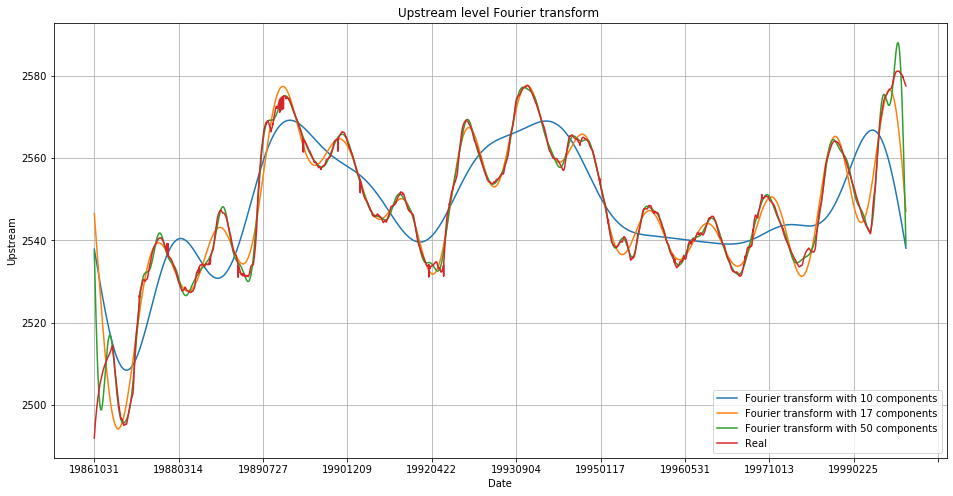

In [7]:
# 画出上游水位傅里叶变换的结果
df = env_frame
plt.figure(figsize = (16,8))
fft = np.fft.fft(np.asarray(df.Upstream))
fft_df = pd.DataFrame({'fft':fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
ax = plt.gca()
x=list(df.index.astype('str'))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [10,ff,50]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(x,np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(x,df.Upstream,  label='Real')
ax.xaxis.set_major_locator(MultipleLocator(500))
plt.xlabel('Date')
plt.ylabel('Upstream')
plt.title('Upstream level Fourier transform ')
plt.legend()
plt.grid()
plt.show()

In [40]:
# 去除极值
def detect_outliers(df):
    outlier_indices = []
    # 1st quartile (15%)
    Q1 = np.percentile(df, 20)
    # 3rd quartile (85%)
    Q3 = np.percentile(df, 80)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.414 * IQR
    index_list = []
    i = 0
    for nu in df:
        if (nu < Q1 - outlier_step) | (nu > Q3 + outlier_step):
            # df.remove(nu)
            index_list.append(i)
        i = i+1
    return df, index_list
# 去除极值
def handle_max_min(data_df):
    data_df = data_df.reset_index()
    _, index = detect_outliers(list(data_df.Crackwidth))
    if len(index):
        for i in index:
            if i>1 and i < data_df.shape[0]-1 \
                    and not np.isnan(list(data_df.Crackwidth)[i-1]) \
                    and not np.isnan(list(data_df.Crackwidth)[i+1]):
                df1 = data_df[i-1:i]
                df2 = data_df[i+1:i+2]
                df = df1.append(df2)
                df3 = df.apply(lambda x: x.sum()/2)
                df4 = data_df[:i]
                df4 = df4.append(df3, ignore_index=True)
                data_df = df4.append(data_df[i+1:])
    return data_df
# 去除异常数据
def remove_abnormal_data(data_df):
    data_df = data_df[~data_df.isin([1000000.000])]
    data_df = data_df[~data_df.Crackwidth.isin([0])]
    data_df = data_df[~data_df.Upstream.isin([0])]
    data_df = data_df[~data_df.Downstream.isin([0])]
    return data_df
# 处理nan，用前一个有效值与后一个有效值的均值代替
def handle_nan(data_df, index):
    # index = list(data_df.index[np.where(np.isnan(data_df.Crackwidth))[0]])
    if len(index):
        for i in index:
            if i and i < data_df.shape[0]-1 \
                    and not np.isnan(list(data_df.Crackwidth)[i-1]) \
                    and not np.isnan(list(data_df.Crackwidth)[i+1]):
                df1 = data_df[i-1:i]
                df2 = data_df[i+1:i+2]
                df = df1.append(df2)
                df3 = df.apply(lambda x: x.sum()/2)
                df4 = data_df[:i]
                df4 = df4.append(df3, ignore_index=True)
                data_df = df4.append(data_df[i+1:])
    return data_df

In [18]:
base = pd.read_csv(csv_path+'/base.csv')
base = base.set_index(base.Date).drop(['Date'], axis=1)
# env_df = Fourier_transforms(env_frame).drop(['Rainfall'], axis=1)
env_df = env_frame.drop(['Rainfall'], axis=1)
env_df.index = env_df.index.astype('int')
for file in get_file(csv_path):
    if 'base' not in file  :#and 'D11J41' in file:
        file_path = os.path.join(csv_path, file)
        df = pd.read_csv(file_path)
        df = df.drop(['Rainfall'], axis=1)
        if 'Date' in list(df.columns):
            df = df.set_index(df.Date).drop(['Date'],axis=1)
        df = df.join(env_df, on=None, how='left', lsuffix='',
                     rsuffix='', sort=False).dropna()
        mean = df.Crackwidth.mean()
        if df.shape[0] > 100 and np.abs(mean) > 0.1:
            df = remove_abnormal_data(df.dropna())
            df.index = df.index/100
            df.index = df.index.astype('int')
            df_h = handle_max_min(df)
            df_h = df_h.set_index(
                df.index).drop(['Date'], axis=1)
            df_h = base.join(df_h, lsuffix='_left', rsuffix='_right')
            df_h = df_h.reset_index()
            index = list(df_h.index[np.where(
                np.isnan(df_h.Crackwidth))[0]])
            df_h = handle_nan(df_h, index)
            
            df_h.Date = df_h.Date.astype('int')
            df_h = df_h.set_index(df_h.Date).drop(
                ['Date'], axis=1).dropna()
            #去除重复index行
            df_h = df_h[~df_h.index.duplicated(keep='first')]
            
            # 标准化
            df_h = df_h.apply(lambda x : (x-np.mean(x))/(np.std(x)))
            # 归一化
            df_h = df_h.apply(lambda x : (x-np.min(x))/(np.max(x)-np.min(x)))
            
            df_h = Fourier_transforms(df_h)
            
            df_h['waterhead'] = df_h.Upstream-df_h.Downstream
            df_h['temp_dif'] = df_h.Temprate-df_h.With_temp
            
            if df_h.shape[0] > 50:
                valid_file = ['D3J5','D4J5','D5J11','D6J7','D9J2','D9J38','D11J24','D13J11','D15J29']
                if file.split('.')[0] in valid_file:
                    filename = os.path.join(valid_path, file)
                    if not os.path.exists(valid_path):
                        os.makedirs(valid_path)
                    df_h.to_csv(filename, sep=',', header=True, index=True)
                if 'D11' in file:

                    if not os.path.exists(test_path):
                        os.makedirs(test_path)
                    filename = os.path.join(test_path, file)
                    df_h.to_csv(filename, sep=',', header=True, index=True)
                else:
                    filename = os.path.join(train_path, file)
                    if not os.path.exists(train_path):
                        os.makedirs(train_path)
                    df_h.to_csv(filename, sep=',', header=True, index=True)

df_h.head() 

,Crackwidth,With_temp,Upstream,Downstream,Temprate,waterhead,temp_dif
Date,,,,,,,
198801,0.000000,0.529591,0.184063,0.156948,0.205527,0.027115,-0.324063
198802,0.045329,0.274422,0.110277,0.236539,0.248675,-0.126263,-0.025746
198803,0.069345,0.154887,0.073581,0.150971,0.365122,-0.077390,0.210235
198804,0.047311,0.055916,-0.015379,0.126209,0.529881,-0.141588,0.473965
198805,0.103879,0.032220,-0.045447,0.157437,0.708212,-0.202884,0.675992


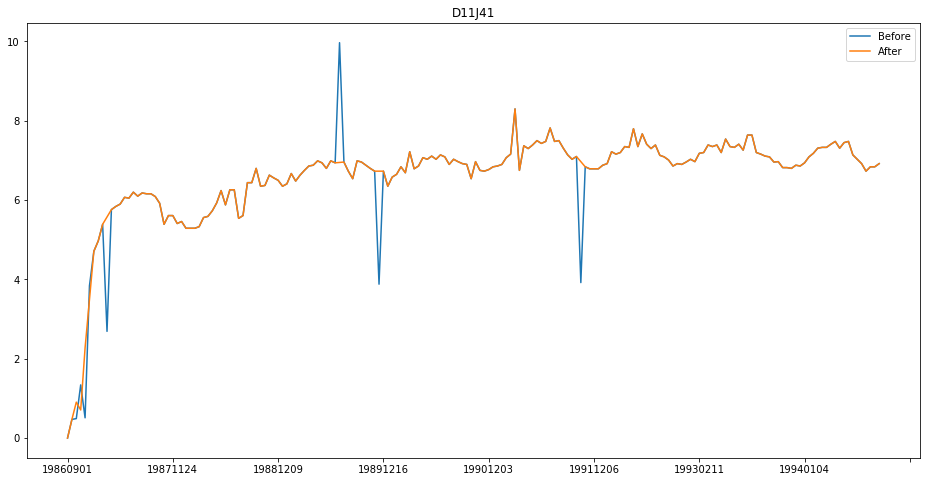

In [42]:
#裂缝D11J41原始数据经过handle_max_min()极值处理前后对比
file_path = os.path.join(save_path, 'D11J41.csv')
data_df = pd.read_csv(file_path).dropna()
data_df = data_df.drop(['Rainfall'],axis=1)
data_df = data_df.set_index(data_df.Date).drop(['Date'], axis=1)
data_df.index = data_df.index.astype('str')
plt.figure(figsize=(16, 8))
ax = plt.gca()
x = list(data_df.index)
plt.plot(x, list(data_df.Crackwidth), label=u'Before')
data_df.index = data_df.index.astype('int')
data_df = handle_max_min(data_df)
plt.plot(x, list(data_df.Crackwidth), label=u'After')
plt.title('D11J41')
ax.xaxis.set_major_locator(MultipleLocator(24))
plt.legend()
plt.show()

# 训练

In [45]:

def plot_results(predicted_data, true_data, file):
    fig = plt.figure(figsize=(18, 18))  # figsize是图片的大小`
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True data')
    plt.plot(predicted_data, label='Predicted data')
    plt.title('Crack'+file.split('.')[0])
    plt.legend()
    plt.savefig("result/"+file.split('.')
                [0]+".png", format='png', transparent=True, dpi=300, pad_inches=0)
# def mae_mse(y_true, y_pred):
#     MAE_loss = K.mean(K.abs(y_pred-y_true), axis=-1)
#     MSE_loss = K.mean(K.square(y_pred-y_true), axis=-1)
#     return MAE_loss*0.1+MSE_loss*0.9


In [108]:
#训练
configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']):
    os.makedirs(configs['model']['save_dir'])

model = Model()
model.build_model(configs)

files = get_file(configs['data']['trainpath'])
file_list = []
data = DataLoader(
    os.path.join(configs['data']['trainpath'],configs['data']['filename']),configs['data']['train_test_split'],configs['data']['columns']
)

x, y = data.get_train_datas(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise'],
    train_path = configs['data']['trainpath']
)

model_file = model.train(x, y, configs,0.)

[Model] Model Compiled
Time taken: 0:00:00.033165
[Model] Training Started
Epoch 1/50
8826/8826 [==============================] - 27s 3ms/step - loss: 0.0589 - mae: 0.0986
Epoch 2/50
8826/8826 [==============================] - 23s 3ms/step - loss: 0.0354 - mae: 0.0635
Epoch 3/50
8826/8826 [==============================] - 23s 3ms/step - loss: 0.0291 - mae: 0.0531
Epoch 4/50
8826/8826 [==============================] - 23s 3ms/step - loss: 0.0265 - mae: 0.0487
Epoch 5/50
8826/8826 [==============================] - 24s 3ms/step - loss: 0.0259 - mae: 0.0477
Epoch 6/50
8826/8826 [==============================] - 23s 3ms/step - loss: 0.0233 - mae: 0.0432
Epoch 7/50
8826/8826 [==============================] - 23s 3ms/step - loss: 0.0215 - mae: 0.0401
Epoch 8/50
8826/8826 [==============================] - 24s 3ms/step - loss: 0.0204 - mae: 0.0382
Epoch 9/50
8826/8826 [==============================] - 23s 3ms/step - loss: 0.0192 - mae: 0.0360
Epoch 10/50
8826/8826 [====================

result/saved_models/22032020-192915-e50.h5

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_33 (Bidirectio (None, 10, 512)           402432    
_________________________________________________________________
dropout_33 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 10, 200)           490400    
_________________________________________________________________
dropout_34 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 10, 200)           240800    
_________________________________________________________________
dropout_35 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
bidirectio

<Figure size 1296x1296 with 0 Axes>

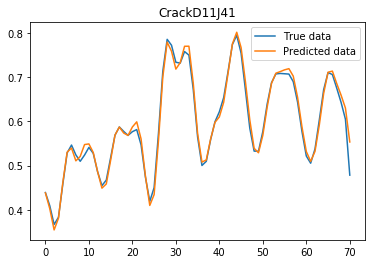

<Figure size 1296x1296 with 0 Axes>

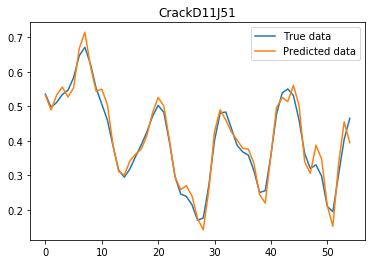

<Figure size 1296x1296 with 0 Axes>

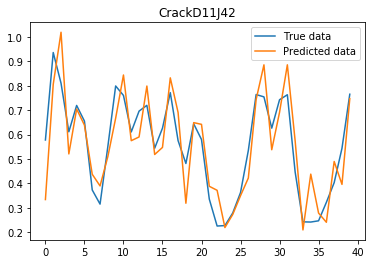

In [47]:
#预测
configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']):
    os.makedirs(configs['model']['save_dir'])

if not model_file:
    model_file = 'result/saved_models/22032020-192915-e50.h5'
print(model_file)
model = load_model(model_file, custom_objects={
                    'mae_mse': mae_mse})

files = get_file(configs['data']['testpath'])
loss_list = []

for file in files:

    data = DataLoader(
        # os.path.join('data\\test', configs['data']['filename']),
        os.path.join(configs['data']['testpath'], file),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    x_test, y_test = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )


    predicted = model.predict(x_test)
    predictions = np.reshape(predicted, (predicted.size,))

    plot_results(predictions, y_test, file)

    pre_df1 = pd.DataFrame(y_test)
    pre_df2 = pd.DataFrame(predictions)
    df = pd.concat([pre_df1, pre_df2], axis=1)
    df.columns = ['real', 'predict']

    filename = os.path.join('result/csv', file)
    df.to_csv(filename, sep=',', header=True, index=False)
model.summary()

In [48]:
#评估
configs = json.load(open('config.json', 'r'))
result_files = get_file(configs['data']['result'])
test_files = get_file(configs['data']['testpath'])
for file in result_files:
    if file in test_files:
        f_result = os.path.join('result/csv', file)
        df_result = pd.read_csv(f_result).dropna()

        f_test = os.path.join(configs['data']['testpath'], file)
        df_test = pd.read_csv(f_test).dropna()[10:-1]

        # df_result['Date'] = df_test.Date

        df_test = df_test.set_index(df_test.Date).drop(['Date'], axis=1)
        df_test.index = df_test.index.astype('str')
        df_result.index = df_test.index

        real_list = list(df_result.real)
        predict_list = list(df_result.predict)

        # 计算重叠率
        overlap = 0
        for i in range(1, (df_result.shape[0])):
            overlap = overlap+np.abs(np.abs(real_list[i]+real_list[i-1])-np.abs(
                predict_list[i]+predict_list[i-1]))/np.abs(real_list[i]+real_list[i-1])
        overlap = 1 - overlap/df_result.shape[0]

        # 计算皮尔逊系数
        pccs = np.corrcoef(real_list, predict_list)

        precision = (overlap + np.abs(pccs[0][1]))/2

        print('裂缝%s 重叠率:%.2f 皮尔逊系数：%.2f 预测精度：%.2f' %
              (file, overlap*100, pccs[0][1]*100, precision*100))


裂缝D11J41.csv 重叠率:98.57 皮尔逊系数：99.24 预测精度：98.91
裂缝D11J51.csv 重叠率:95.67 皮尔逊系数：97.96 预测精度：96.81
裂缝D11J42.csv 重叠率:89.08 皮尔逊系数：87.33 预测精度：88.21
